In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import *
from skimage.filters import *
from skimage.util import invert
from skimage.feature import canny, peak_local_max
from skimage.transform import rotate
from skimage.morphology import disk
import os
from scipy import ndimage as nd
from scipy.signal import find_peaks

In [2]:
images_path = os.path.join('dataset', 'images')

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1):
    return tuple(map(get, np.random.choice(os.listdir(images_path), k)))

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def peaks_filter(x:np.array, y:np.array, peaks:np.array, k:int=1):
    ypeaks = y[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def pixel_scale(image:np.array):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = find_peaks(ymean), find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

def pixel_scale_1d(sig1d:np.array):
    fft = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig1d))))
    freqs = np.fft.ifftshift(np.fft.fftfreq(len(fft), 1))
    
    peaks, _ = find_peaks(fft)
    P = peaks_filter(freqs, fft, peaks, 2)
    
    return np.abs(freqs[P][0])

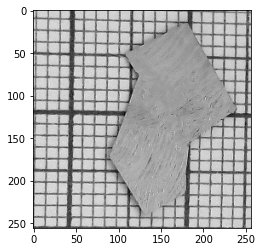

In [196]:
#image = by_id(150)
image = random_images()[0]
img = rgb2gray(image)
plt.imshow(img, cmap='gray')

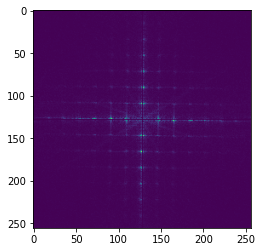

In [197]:
ifft = fft2d(img)
fft = np.abs(ifft)
freqs = np.stack(np.meshgrid(
    np.fft.ifftshift(np.fft.fftfreq(img.shape[0])),
    np.fft.ifftshift(np.fft.fftfreq(img.shape[1]))
), axis=2)
fftfilter = freqs != np.zeros(freqs.shape)
plt.imshow(np.where(fftfilter[:, :, 0] & fftfilter[:, :, 1], fft, 0))

In [198]:
Fx, Fy = pixel_scale(img)
Fx, Fy

(0.07421875, 0.07421875)

In [199]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

kernel_x = gabor_kernel(Fx, theta=0)
kernel_y = gabor_kernel(Fy, theta=np.pi/2)

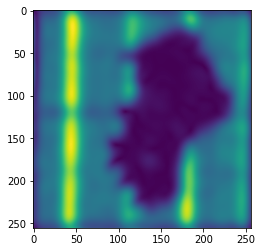

In [200]:
gabor_x = power(img, kernel_x)
plt.imshow(gabor_x)

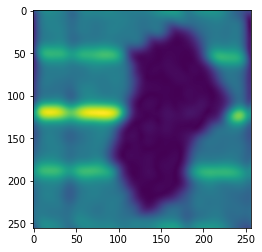

In [201]:
gabor_y = power(img, kernel_y)
plt.imshow(gabor_y)

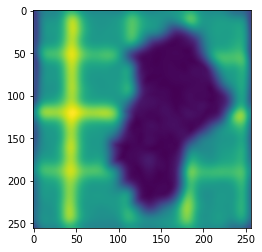

In [202]:
filtered = gabor_x + gabor_y
plt.imshow(filtered)

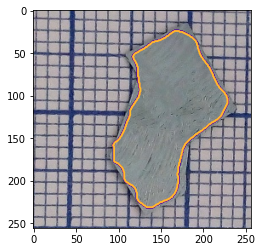

In [203]:
plt.imshow(image)
plt.contour(filtered < threshold_minimum(filtered), cmap='plasma')

In [218]:
X, Y = np.meshgrid(np.linspace(0, 2*np.pi, 100), np.linspace(0, 2*np.pi, 100))
Zx = np.exp(2j*np.pi*X/fx)
Zy = np.exp(2j*np.pi*Y/fy)

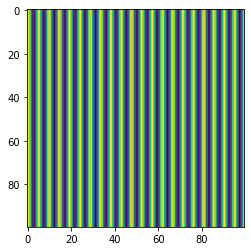

In [221]:
plt.imshow(np.real(Zx*np.exp(5j)))